In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt

import json
import os
import re
import torch

from collections import Counter, defaultdict
from itertools import islice

%matplotlib inline

In [69]:
def get_results(version:str='train'):
    subdir = './results_train/' if version == 'train' else './results_test/'
    all_files = list(map(lambda f: subdir + f, os.listdir(subdir)))
    all_results = defaultdict(dict)
    for file in islice(all_files, 1, None):
        with open(file) as f:
            r = json.load(f)
            for metric, values in r.items():
                all_results[file][metric] = values
    return dict(all_results)

  
def plot_results(results:dict, metric:str='train_loss', models='optims'):
    r_plot = {}
    for clf, r in results.items():
        if re.search(r'linear', clf) and re.search(r'(subjqa|squad|combined)', clf) and re.search(r'singletask', clf) and not re.search(r'highway', clf):
            for m, v in r.items():
                if re.search(r'' + metric, m):
                    r_plot[clf] = v
    if models == 'optims':
        params = ['AdamW', 'Adam', 'SGDCos', 'SGD']
    elif models == 'dataset':
        params = ['SQuAD + SubjQA', 'SQuAD', 'SubjQA']
        
    for idx, (model, met) in enumerate(r_plot.items()):
        plt.plot(range(1, len(met) + 1), met, '-o', label=params[idx])
        
    plt.legend(fancybox=True, shadow=True, loc='upper left')
    plt.xticks(range(1, 6))
    if metric == 'train_loss':
        plt.yticks(range(1, 7))
    plt.xlabel('Epochs', fontsize=12)
    if metric == 'train_acc' or metric == 'val_acc':
        plt.ylabel('Accuracy', fontsize=12)
    elif metric == 'train_f1' or metric == 'val_f1':
        plt.ylabel('F1', fontsize=12)
    elif metric == 'train_loss' or metric == 'val_loss':
        plt.ylabel('Loss', fontsize=12)
    #plt.savefig('./plots/' + models + '/' + metric + '.png')
    plt.show()

In [65]:
all_results = get_results()

In [66]:
all_results = {model: results for model, results in all_results.items() if re.search(r'distilbert', model)}

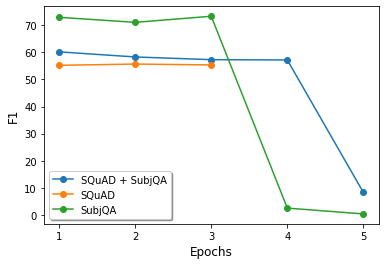

In [67]:
plot_results(all_results, metric='val_f1', models='dataset')

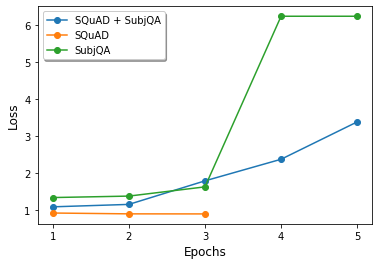

In [75]:
plot_results(all_results, metric='val_loss', models='dataset')